In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/vantuan_ngo/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
import os
import glob
import scipy.io

def load_train_data(path):
    data = []
    # List all .mat files in the given path
    mat_files = glob.glob(os.path.join(path, "*.mat"))
    print(mat_files)
    for file in mat_files:
        mat_data = scipy.io.loadmat(file)
        NI_IQ = mat_data['NI_IQ'].transpose(2, 0, 1)  # Convert from (H,W,C) to (C,H,W)
        NI_IQ = NI_IQ[:2, :, :].astype(np.float32)  # Convert to float32
        if NI_IQ.shape != (2, 300, 14):
            print(f"Skipping file {file} with unexpected shape: {NI_IQ.shape}")
            continue
        if torch.isnan(torch.tensor(NI_IQ)).any() or torch.isinf(torch.tensor(NI_IQ)).any():
            print(f"Warning: Invalid values (NaN/Inf) in {file}")
            continue
        data.append(NI_IQ)
    return data

train_good_dataset = load_train_data("../datasets/FccIQ/synthetic/train/good")
print(len(train_good_dataset))
print(train_good_dataset[0].shape)

# Normalize the loaded data to [0,1] range
def normalize_data(data_list):
    # Find global min and max across all data
    all_data = np.concatenate(data_list, axis=0)
    global_min = -3
    global_max = 3
    
    print(f"Global data range: [{global_min:.6f}, {global_max:.6f}]")
    
    # Normalize each sample to [0, 1] range
    normalized_data = []
    for data in data_list:
        # Ensure data is within [0, 1] range
        normalized = np.clip((data - global_min) / (global_max - global_min + 1e-8), 0, 1)
        normalized_data.append(normalized)
    
    return normalized_data

# Normalize the training dataset
train_good_dataset = normalize_data(train_good_dataset)
print(f"Normalized dataset size: {len(train_good_dataset)}")
print(f"Sample normalized data range: [{train_good_dataset[0].min():.6f}, {train_good_dataset[0].max():.6f}]")

['../datasets/FccIQ/synthetic/train/good/MCS_24_SNR_18_NI_7_slot_7.mat', '../datasets/FccIQ/synthetic/train/good/MCS_8_SNR_38_NI_3_slot_3.mat', '../datasets/FccIQ/synthetic/train/good/MCS_22_SNR_14_NI_5_slot_10.mat', '../datasets/FccIQ/synthetic/train/good/MCS_1_SNR_8_NI_48_slot_48.mat', '../datasets/FccIQ/synthetic/train/good/MCS_8_SNR_34_NI_14_slot_14.mat', '../datasets/FccIQ/synthetic/train/good/MCS_14_SNR_8_NI_10_slot_17.mat', '../datasets/FccIQ/synthetic/train/good/MCS_2_SNR_42_NI_33_slot_33.mat', '../datasets/FccIQ/synthetic/train/good/MCS_2_SNR_34_NI_30_slot_30.mat', '../datasets/FccIQ/synthetic/train/good/MCS_8_SNR_46_NI_2_slot_2.mat', '../datasets/FccIQ/synthetic/train/good/MCS_10_SNR_38_NI_11_slot_11.mat', '../datasets/FccIQ/synthetic/train/good/MCS_1_SNR_42_NI_62_slot_62.mat', '../datasets/FccIQ/synthetic/train/good/MCS_26_SNR_34_NI_6_slot_6.mat', '../datasets/FccIQ/synthetic/train/good/MCS_1_SNR_38_NI_102_slot_102.mat', '../datasets/FccIQ/synthetic/train/good/MCS_2_SNR_6_NI

In [3]:
# Loss function
# def AE_loss(recon_x, x, mu, logvar, beta=1.0):
#     # Check for NaNs or invalid values in recon_x and x
#     if torch.isnan(recon_x).any() or torch.isnan(x).any():
#         raise ValueError("NaN detected in recon_x or x")
#     if (recon_x < 0).any() or (recon_x > 1).any():
#         raise ValueError("recon_x contains values outside [0, 1]")
#     if (x < 0).any() or (x > 1).any():
#         print(x.min())
#         print(x.max())
#         raise ValueError("x contains values outside [0, 1]")

#     # Check shapes
#     if recon_x.shape != x.shape:
#         raise ValueError(f"Shape mismatch: recon_x {recon_x.shape}, x {x.shape}")

#     # recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
#     # kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     # return recon_loss + beta * kl_loss

#     # Calculate reconstruction loss using sum of squared distances
#     recon_loss = torch.sum((recon_x - x) ** 2)
#     print(f"Recon loss: {recon_loss.item():.6f}")

#     kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     print(f"KL loss: {beta * kl_loss.item():.6f}")

#     loss = recon_loss + beta * kl_loss
#     print(f"Total loss: {loss.item():.6f}")
#     return loss

def AE_loss(recon, data, mu, logvar, beta=1.0):
    # Reconstruction loss (e.g., MSE)
    recon_loss = torch.nn.functional.mse_loss(recon, data, reduction='sum')
    # KL-divergence
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_div

# Generate synthetic WGN images (normal data)
def generate_wgn_images(num_samples, height=28, width=28, channels=1):
    images = np.random.normal(loc=0.5, scale=0.1, size=(num_samples, channels, height, width))
    images = np.clip(images, 0, 1)
    return torch.tensor(images, dtype=torch.float32)

# Generate anomalous images (WGN + bright straight line)
def generate_anomalous_images(num_samples, height=28, width=28, channels=1):
    images = np.random.normal(loc=0.5, scale=0.1, size=(num_samples, channels, height, width))
    for i in range(num_samples):
        # Add a horizontal straight line with high brightness (e.g., value 0.9)
        line_position = np.random.randint(height // 4, 3 * height // 4)  # Random row for variety
        for c in range(channels):
            images[i, c, line_position, :] = 0.9  # Set entire row to high brightness
    images = np.clip(images, 0, 1)
    return torch.tensor(images, dtype=torch.float32)

# Training function
def train_AE(model, data_loader, epochs=20, learning_rate=1e-4, beta=1.0):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, data in enumerate(data_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = AE_loss(recon_batch, data, mu, logvar, beta)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(data_loader.dataset):.6f}")

# Anomaly detection
def detect_anomalies(model, data_loader, threshold):
    model.eval()
    anomalies = []
    recon_errors = []
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            recon, _, _ = model(data)
            recon_error = nn.functional.mse_loss(recon, data, reduction='none').mean(dim=(1,2,3))
            recon_errors.extend(recon_error.cpu().numpy())
            anomalies.extend((recon_error > threshold).cpu().numpy())
    return np.array(anomalies), np.array(recon_errors)

# Generate anomaly map
def generate_anomaly_map(original, reconstructed):
    # Convert numpy arrays to torch tensors if needed
    if isinstance(original, np.ndarray):
        original = torch.tensor(original, dtype=torch.float32)
    if isinstance(reconstructed, np.ndarray):
        reconstructed = torch.tensor(reconstructed, dtype=torch.float32)
    
    anomaly_map = (original - reconstructed)**2 # Use ** instead of .pow()
    # print("anomaly_map.shape before sum", anomaly_map.shape)
    anomaly_map = torch.sum(anomaly_map, dim=(1), keepdim=True)
    # print("anomaly_map.shape after sum", anomaly_map.shape)
    # Normalize anomaly map to range [0, 1]
    # anomaly_map = anomaly_map - anomaly_map.mean()
    # anomaly_map = (anomaly_map - anomaly_map.min()) / (anomaly_map.max() - anomaly_map.min())
    return anomaly_map

# Visualize anomaly maps
def visualize_anomaly_maps(model, test_data, num_samples=5):
    model.eval()
    with torch.no_grad():
        sample_data = test_data[:num_samples].to(device)
        recon, _, _ = model(sample_data)
        anomaly_maps = generate_anomaly_map(sample_data, recon)
        recon_errors = nn.functional.mse_loss(recon, sample_data, reduction='none').mean(dim=(1,2,3)).cpu().numpy()

        plt.figure(figsize=(15, 4))
        for i in range(num_samples):
            # Original
            plt.subplot(3, num_samples, i + 1)
            plt.imshow(sample_data[i].cpu().squeeze(), cmap='gray')
            plt.title("Anomalous")
            plt.axis('off')
            # Reconstructed
            plt.subplot(3, num_samples, i + 1 + num_samples)
            plt.imshow(recon[i].cpu().squeeze(), cmap='gray')
            plt.title(f"Error: {recon_errors[i]:.4f}")
            plt.axis('off')
            # Anomaly Map
            plt.subplot(3, num_samples, i + 1 + 2 * num_samples)
            plt.imshow(anomaly_maps[i].cpu().squeeze(), cmap='gray')
            plt.title("Anomaly Map")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

In [4]:
import torch
import torch.nn as nn

class AE(nn.Module):
    def __init__(self, input_channels=2, latent_dim=16, img_height=300, img_width=14):
        super(AE, self).__init__()
        self.latent_dim = latent_dim
        self.img_height = img_height
        self.img_width = img_width

        # Calculate feature map size after convolutions
        def calc_feature_size(h, w):
            # First conv: kernel=(5,3), stride=(2,1), padding=(2,1)
            h = (h - 5 + 2 * 2) // 2 + 1  # Height after first conv
            w = (w - 3 + 2 * 1) // 1 + 1  # Width after first conv
            # Second conv: kernel=(5,3), stride=(2,1), padding=(2,1)
            h = (h - 5 + 2 * 2) // 2 + 1  # Height after second conv
            w = (w - 3 + 2 * 1) // 1 + 1  # Width after second conv
            return h, w

        feat_h, feat_w = calc_feature_size(img_height, img_width)
        self.feature_dim = 32 * feat_h * feat_w  # 32 filters in last conv layer

        # Debug feature map
        print(f"Calculated feature map: [32, {feat_h}, {feat_w}], feature_dim={self.feature_dim}")

        # Validate feature map size
        if feat_h <= 0 or feat_w <= 0:
            raise ValueError(f"Invalid feature map size: {feat_h}x{feat_w}")

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=(5, 3), stride=(2, 1), padding=(2, 1)),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=(5, 3), stride=(2, 1), padding=(2, 1)),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(self.feature_dim, 128),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, self.feature_dim)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (32, feat_h, feat_w)),
            nn.ConvTranspose2d(
                32, 16, kernel_size=(5, 3), stride=(2, 1), padding=(2, 1), output_padding=(1, 0)
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                16, input_channels, kernel_size=(5, 3), stride=(2, 1), padding=(2, 1), output_padding=(1, 0)
            ),
            nn.Sigmoid()
        )

        # Verify output size
        test_input = torch.zeros(1, input_channels, img_height, img_width)
        recon, _, _ = self.forward(test_input)
        expected_shape = (input_channels, img_height, img_width)
        if recon.shape[1:] != expected_shape:
            raise ValueError(
                f"Output shape {recon.shape[1:]} does not match expected {expected_shape}"
            )
        print(f"Output shape verified: {recon.shape[1:]}")

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_input(z)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

In [5]:
latent_dim = 16
ae = AE(input_channels=2, latent_dim=latent_dim, img_height=300, img_width=14).to(device)

Calculated feature map: [32, 75, 14], feature_dim=33600
Output shape verified: torch.Size([2, 300, 14])


In [6]:
batch_size = 512
train_loader = DataLoader(train_good_dataset, batch_size=batch_size, shuffle=True)
i, data = next(enumerate(train_loader))
print(i)
print(data.shape)

0
torch.Size([512, 2, 300, 14])


In [7]:
epochs = 100
beta = 1.0
train_AE(ae, train_loader, epochs=epochs, learning_rate=1e-2, beta=beta)

Epoch 1/100, Loss: 199.219130
Epoch 2/100, Loss: 16.460687
Epoch 3/100, Loss: 13.508748
Epoch 4/100, Loss: 12.402016
Epoch 5/100, Loss: 12.158415
Epoch 6/100, Loss: 12.026059
Epoch 7/100, Loss: 11.987827
Epoch 8/100, Loss: 11.962340
Epoch 9/100, Loss: 11.944057
Epoch 10/100, Loss: 11.932050
Epoch 11/100, Loss: 11.921927
Epoch 12/100, Loss: 11.914726
Epoch 13/100, Loss: 11.908833
Epoch 14/100, Loss: 11.904940
Epoch 15/100, Loss: 11.902616
Epoch 16/100, Loss: 11.900296
Epoch 17/100, Loss: 11.898069
Epoch 18/100, Loss: 11.896819
Epoch 19/100, Loss: 11.896265
Epoch 20/100, Loss: 11.894420
Epoch 21/100, Loss: 11.894350
Epoch 22/100, Loss: 11.894016
Epoch 23/100, Loss: 11.893659
Epoch 24/100, Loss: 11.893020
Epoch 25/100, Loss: 11.892713
Epoch 26/100, Loss: 11.892514
Epoch 27/100, Loss: 11.892321
Epoch 28/100, Loss: 11.892278
Epoch 29/100, Loss: 11.892099
Epoch 30/100, Loss: 11.891863
Epoch 31/100, Loss: 11.891940
Epoch 32/100, Loss: 11.891754
Epoch 33/100, Loss: 11.891672
Epoch 34/100, Loss

In [8]:
import os
from datetime import datetime

MODEL_DIR = './models'

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

model_file_name = f"ae_{datetime.now().strftime('%Y_%m_%d_%H_%M_%S')}.pth"
model_file_path = os.path.join(MODEL_DIR, model_file_name)

# Optionally, save the entire model (including architecture)
torch.save(ae, model_file_path)
print(f"Full model saved to {model_file_path}")

# Create a softlink to the latest model
import os

# Create softlink to the latest model
latest_model_link = os.path.join(MODEL_DIR, 'ae_latest.pth')
print(f"Latest model link: {latest_model_link}")
if os.path.lexists(latest_model_link):
    print(f"Removing existing link: {latest_model_link}")
    os.remove(latest_model_link)  # Remove existing link if it exists

os.symlink(os.path.join("./", model_file_name), latest_model_link)
print(f"Softlink created: {latest_model_link} -> {model_file_path}")


Full model saved to ./models/ae_2025_06_27_16_44_38.pth
Latest model link: ./models/ae_latest.pth
Softlink created: ./models/ae_latest.pth -> ./models/ae_2025_06_27_16_44_38.pth


In [9]:
import scipy.io
import numpy as np
import torch
import matplotlib.pyplot as plt

def test_AE(path):
    test_data = scipy.io.loadmat(path)
    # Extract the IQ data
    iq_data = test_data['NI_IQ']  # Assuming the key is 'data', adjust if different
    print(f"Test data shape: {iq_data.shape}")

    iq_data = iq_data.transpose(2, 0, 1)  # Convert from (H,W,C) to (C,H,W)
    iq_data = iq_data[:2, :, :].astype(np.float32)  # Convert to float32
    iq_data = (iq_data - (-3)) / 6
    print(f"Normalized data shape: {iq_data.shape}")

    # Convert to tensor and add batch dimension
    test_tensor = torch.tensor(iq_data, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
    print(f"Tensor shape: {test_tensor.shape}")

    # Move to device
    test_tensor = test_tensor.to(device)

    # Encode the test sample
    with torch.no_grad():
        recon, mu, logvar = ae(test_tensor)  # Get all outputs from AE
        # z = ae.reparameterize(mu, logvar)

    # Calculate reconstruction error
    import torch.nn.functional as F
    mse_loss = F.mse_loss(recon, test_tensor)
    print(f"Reconstruction MSE: {mse_loss.item():.6f}")

    print(f"Original shape: {test_tensor.shape}")
    print(f"Reconstructed shape: {recon.shape}")
    # print(f"Latent representation shape: {z.shape}")

    print(f"Recon min: {recon.min().item():.6f}")
    print(f"Recon max: {recon.max().item():.6f}")
    # print(z)

    # # Save test_tensor and recon to text files
    # np.savetxt('test_tensor.txt', test_tensor.cpu().numpy().flatten(), fmt='%.6f')
    # np.savetxt('recon.txt', recon.cpu().numpy().flatten(), fmt='%.6f')
    
    # # Also save the shapes for reference
    # with open('shapes.txt', 'w') as f:
    #     f.write(f"test_tensor shape: {test_tensor.shape}\n")
    #     f.write(f"recon shape: {recon.shape}\n")
    #     f.write(f"test_tensor flattened size: {test_tensor.cpu().numpy().flatten().shape}\n")
    #     f.write(f"recon flattened size: {recon.cpu().numpy().flatten().shape}\n")
    # # Visualize the original vs reconstructed
    # plt.figure(figsize=(15, 5))

    # Get the data for consistent colorbar scaling
    original_data = test_tensor.cpu().numpy()[0, 0]
    recon_data = recon.cpu().numpy()[0, 0]
    
    # Find global min and max for consistent colorbar
    vmin = min(original_data.min(), recon_data.min())
    vmax = max(original_data.max(), recon_data.max())
    
    plt.subplot(1, 3, 1)
    plt.imshow(original_data, cmap='viridis', vmin=0, vmax=1)
    plt.title('Original Signal')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.imshow(recon_data, cmap='viridis', vmin=0, vmax=1)
    plt.title('Reconstructed Signal')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.colorbar()

    anomaly_map = generate_anomaly_map(test_tensor, recon)
    print(anomaly_map.shape)
    plt.subplot(1, 3, 3)
    plt.imshow(anomaly_map.cpu().numpy()[0, 0], cmap='gray')
    plt.title('Anomaly Map')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

Test data shape: (300, 14, 3)
Normalized data shape: (2, 300, 14)
Tensor shape: torch.Size([1, 2, 300, 14])
Reconstruction MSE: 0.000000
Original shape: torch.Size([1, 2, 300, 14])
Reconstructed shape: torch.Size([1, 2, 300, 14])
Recon min: 0.500006
Recon max: 0.500008
torch.Size([1, 1, 300, 14])


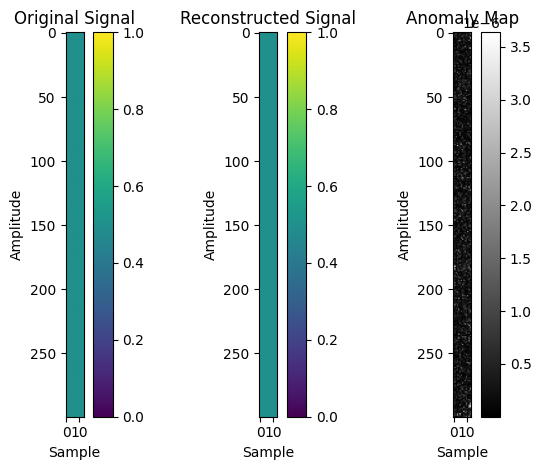

In [10]:
# Load and visualize a test sample
test_file_path = "/home/vantuan_ngo/anomalib-example/datasets/FccIQ/synthetic/train/good/MCS_28_SNR_50_NI_2_slot_2.mat"
test_AE(test_file_path)

Test data shape: (300, 14, 3)
Normalized data shape: (2, 300, 14)
Tensor shape: torch.Size([1, 2, 300, 14])
Reconstruction MSE: 0.001507
Original shape: torch.Size([1, 2, 300, 14])
Reconstructed shape: torch.Size([1, 2, 300, 14])
Recon min: 0.500006
Recon max: 0.500008
torch.Size([1, 1, 300, 14])


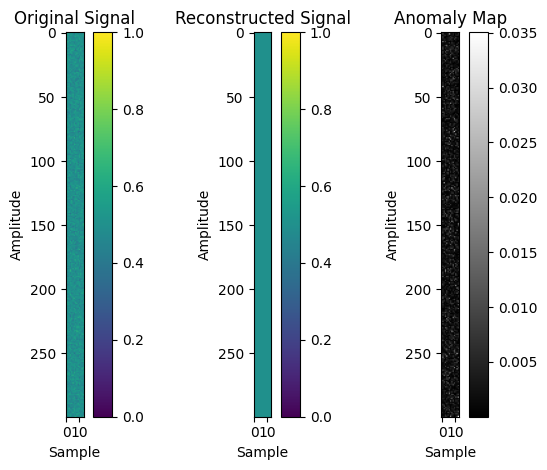

In [11]:
# Load and visualize a test sample
test_file_path = "/home/vantuan_ngo/anomalib-example/datasets/FccIQ/synthetic/train/good/MCS_28_SNR_10_NI_5_slot_15.mat"
test_AE(test_file_path)

Test data shape: (300, 14, 3)
Normalized data shape: (2, 300, 14)
Tensor shape: torch.Size([1, 2, 300, 14])
Reconstruction MSE: 0.000262
Original shape: torch.Size([1, 2, 300, 14])
Reconstructed shape: torch.Size([1, 2, 300, 14])
Recon min: 0.500006
Recon max: 0.500008
torch.Size([1, 1, 300, 14])


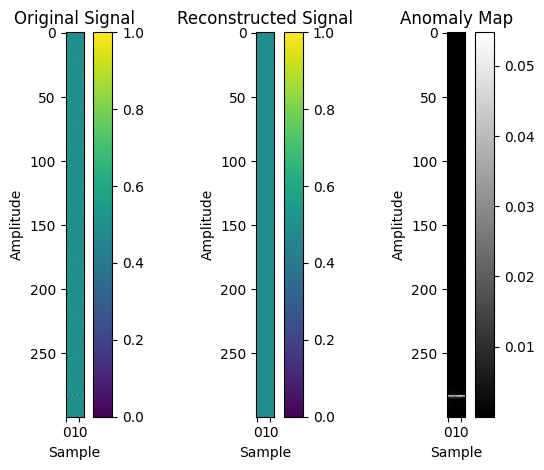

In [12]:
# Load and visualize a test sample
test_file_path = "/home/vantuan_ngo/anomalib-example/datasets/FccIQ/synthetic/test/singletone/100.mat"
test_AE(test_file_path)

Test data shape: (300, 14, 3)
Normalized data shape: (2, 300, 14)
Tensor shape: torch.Size([1, 2, 300, 14])
Reconstruction MSE: 0.000000
Original shape: torch.Size([1, 2, 300, 14])
Reconstructed shape: torch.Size([1, 2, 300, 14])
Recon min: 0.500006
Recon max: 0.500008
torch.Size([1, 1, 300, 14])


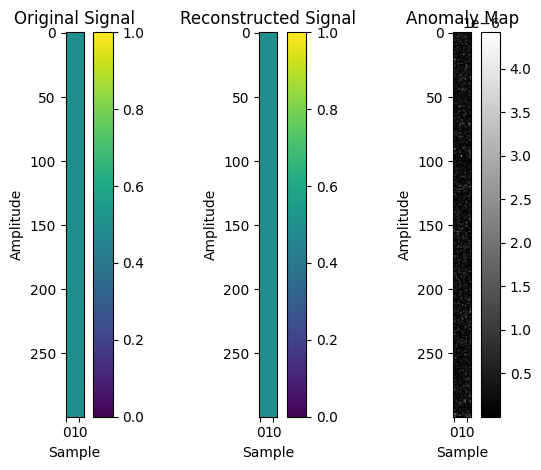

In [13]:
# Load and visualize a test sample
test_file_path = "/home/vantuan_ngo/anomalib-example/datasets/FccIQ/synthetic/train/good/MCS_28_SNR_50_NI_4_slot_4.mat"
test_AE(test_file_path)

In [14]:
import os
import glob
import scipy.io
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

def load_test_data(test_path, label_path):
    test_data = []
    label_data = []
    mat_files = glob.glob(os.path.join(test_path, "*.mat"))
    print(f"Found {len(mat_files)} .mat files")

    for file in mat_files:
        file_name = os.path.basename(file)
        label_file = os.path.join(label_path, file_name)

        # Load and process IQ data
        try:
            mat_data = scipy.io.loadmat(file)
            NI_IQ = mat_data['NI_IQ'].transpose(2, 0, 1)  # (H,W,C) to (C,H,W)
            NI_IQ = NI_IQ[:2, :, :].astype(np.float32)  # First two channels
            if NI_IQ.shape != (2, 300, 14):
                print(f"Skipping {file}: unexpected shape {NI_IQ.shape}")
                continue
            if np.isnan(NI_IQ).any() or np.isinf(NI_IQ).any():
                print(f"Warning: NaN/Inf in {file}")
                continue
            NI_IQ = np.clip((NI_IQ - (-3)) / 6, 0, 1)
            test_data.append(NI_IQ)

            # Load and process label data
            label_mat_data = scipy.io.loadmat(label_file)
            label_mat = label_mat_data['InterferenceGrid_abs'].astype(np.float32)
            label_mat = label_mat.reshape(1, 300, 14)
            if label_mat.shape != (1, 300, 14):
                print(f"Skipping {label_file}: unexpected shape {label_mat.shape}")
                continue
            if np.isnan(label_mat).any() or np.isinf(label_mat).any():
                print(f"Warning: NaN/Inf in {label_file}")
                continue
            
            label_mat = label_mat - label_mat.mean()
            label_mat = np.clip((label_mat - label_mat.min()) / (label_mat.max() - label_mat.min()), 0, 1)
            label_data.append(label_mat)

        except Exception as e:
            print(f"Error processing {file}: {e}")
            continue

    if not test_data:
        raise ValueError("No valid data loaded")
    
    # Convert to tensors
    test_data = torch.tensor(np.stack(test_data))  # Shape: (N, 2, 300, 14)
    label_data = torch.tensor(np.stack(label_data))  # Shape: (N, 1, 300, 14)
    return test_data, label_data

# Load data
test_path = "../datasets/FccIQ/synthetic/test/singletone"
label_path = "../datasets/FccIQ/synthetic/ground_truth/singletone"
test_data, label_data = load_test_data(test_path, label_path)
print(f"Loaded {len(test_data)} test samples")
print(f"Test data shape: {test_data.shape}")
print(f"Label data shape: {label_data.shape}")

# Normalize label_data to [0, 1] range
# print(f"Label data - min: {label_data.min():.4f}, max: {label_data.max():.4f}")
# label_data = (label_data - label_data.min()) / (label_data.max() - label_data.min())
# print(f"Label data normalized - min: {label_data.min():.4f}, max: {label_data.max():.4f}")

# Create TensorDataset
test_dataset = TensorDataset(test_data, label_data)


Found 1176 .mat files
Loaded 1176 test samples
Test data shape: torch.Size([1176, 2, 300, 14])
Label data shape: torch.Size([1176, 1, 300, 14])


In [15]:
# Create test loader for all data
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
i, (test_sample, label_sample) = next(enumerate(test_loader))
print(test_sample.shape)
print(label_sample.shape)

torch.Size([1, 2, 300, 14])
torch.Size([1, 1, 300, 14])


In [16]:
from sklearn.metrics import f1_score

# Test Autoencoder
print("Testing Autoencoder...")

# Test reconstruction on all test data
with torch.no_grad():

    total_anomaly_loss = 0
    total_samples = 0
    total_f1 = 0
    
    print("Testing reconstruction on all test data...")
    
    for batch_idx, (test_batch, label_batch) in enumerate(test_loader):
        # Move to device
        test_batch = test_batch.to(device)
        label_batch = label_batch.to(device)

        # Forward pass
        reconstructed, mu, logvar = ae(test_batch)
        anomaly_map = generate_anomaly_map(test_batch, reconstructed)
        # print(anomaly_map.shape)
        # print(label_batch.shape)

        # Calculate reconstruction loss
        anomaly_loss = torch.nn.functional.mse_loss(anomaly_map, label_batch)
        total_anomaly_loss += anomaly_loss.item() * test_batch.size(0)
        total_samples += test_batch.size(0)
        
        # Calculate F1 score
        # Convert predictions to binary (threshold at 0.5)
        anomaly_bin = (anomaly_map > 10*anomaly_map.mean()).float()
        label_bin = (label_batch > 10*label_batch.mean()).float()
        f1 = f1_score(label_bin.cpu().numpy().flatten(), anomaly_bin.cpu().numpy().flatten())
        total_f1 += f1 * test_batch.size(0)

        if batch_idx == 0:
            print(f"First batch - Original shape: {test_batch.shape}")
            print(f"First batch - Reconstructed shape: {reconstructed.shape}")
            print(f"First batch - Latent space shape: mu={mu.shape}, logvar={logvar.shape}")
            print(f"First batch - Reconstruction Loss: {anomaly_loss.item():.6f}")

        if (batch_idx + 1) % 10 == 0:
            print(f"Processed {batch_idx + 1} batches...")
    
    avg_anomaly_loss = total_anomaly_loss / total_samples
    avg_f1 = total_f1 / total_samples
    print(f"\nTesting completed!")
    print(f"Total samples tested: {total_samples}")
    print(f"Average Anomaly Loss: {avg_anomaly_loss:.6f}")
    print(f"Average F1 score: {avg_f1:.6f}")

print("Autoencoder testing completed!")


Testing Autoencoder...
Testing reconstruction on all test data...
First batch - Original shape: torch.Size([1, 2, 300, 14])
First batch - Reconstructed shape: torch.Size([1, 2, 300, 14])
First batch - Latent space shape: mu=torch.Size([1, 16]), logvar=torch.Size([1, 16])
First batch - Reconstruction Loss: 0.004812
Processed 10 batches...
Processed 20 batches...
Processed 30 batches...
Processed 40 batches...
Processed 50 batches...
Processed 60 batches...
Processed 70 batches...
Processed 80 batches...
Processed 90 batches...
Processed 100 batches...
Processed 110 batches...
Processed 120 batches...
Processed 130 batches...
Processed 140 batches...
Processed 150 batches...
Processed 160 batches...
Processed 170 batches...
Processed 180 batches...
Processed 190 batches...
Processed 200 batches...
Processed 210 batches...
Processed 220 batches...
Processed 230 batches...
Processed 240 batches...
Processed 250 batches...
Processed 260 batches...
Processed 270 batches...
Processed 280 batc

Testing Autoencoder...
Testing reconstruction on all test data...
First batch - Original shape: torch.Size([1, 2, 300, 14])
First batch - Reconstructed shape: torch.Size([1, 2, 300, 14])
First batch - Latent space shape: mu=torch.Size([1, 16]), logvar=torch.Size([1, 16])
First batch - Reconstruction Loss: 0.004812
Processed 40 batches...
test_batch[0].shape torch.Size([2, 300, 14])
anomaly_map[0].shape torch.Size([1, 300, 14])
label_batch[0].shape torch.Size([1, 300, 14])
anomaly_bin[0].shape torch.Size([1, 300, 14])
label_bin[0].shape torch.Size([1, 300, 14])


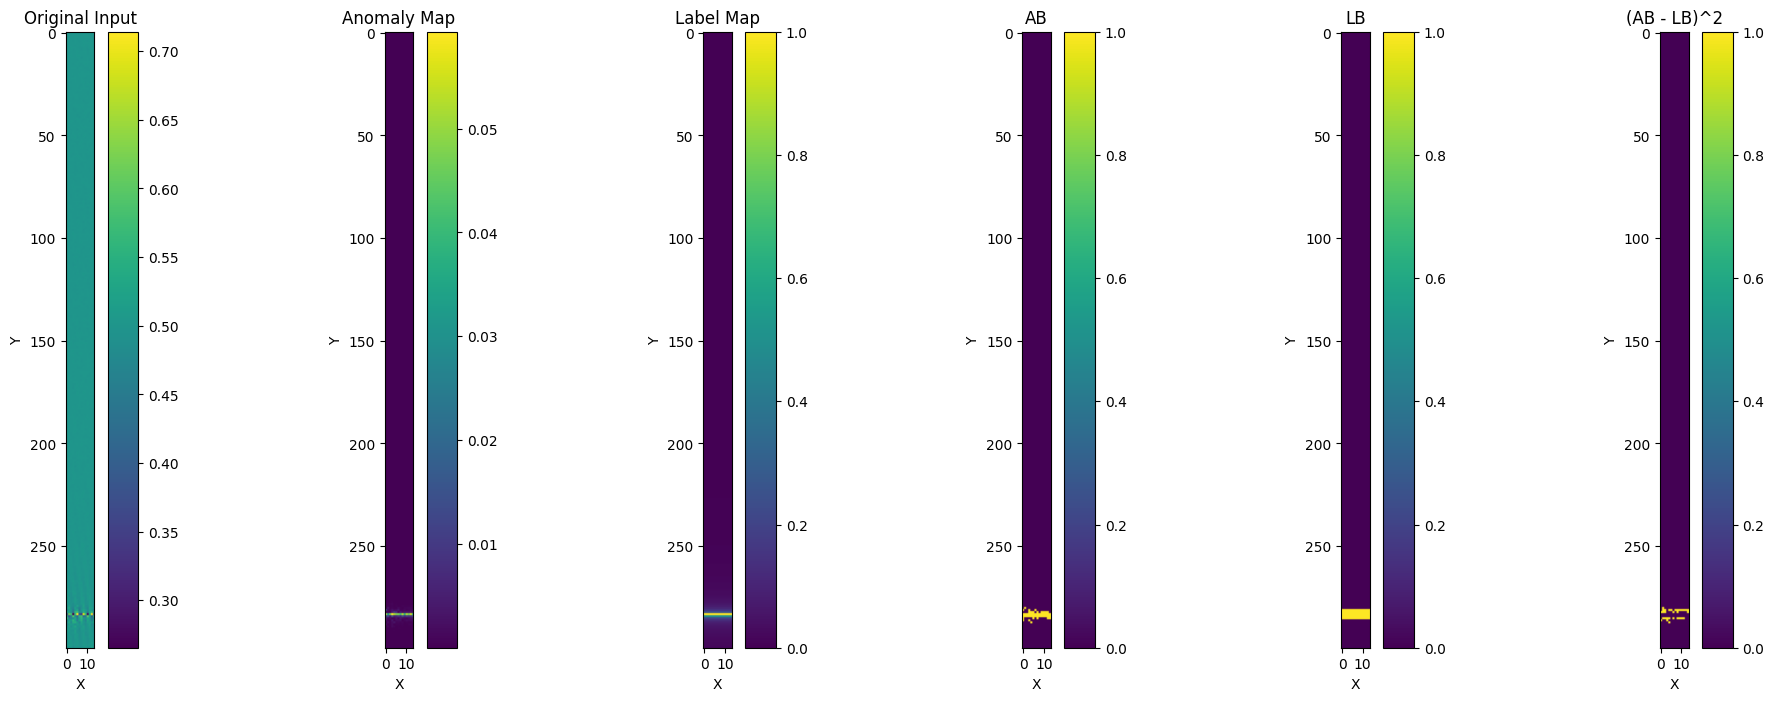


Testing completed!
Total samples tested: 40
Average Anomaly Loss: 0.004096
Average F1 score: 0.548518
Autoencoder testing completed!


In [17]:
from sklearn.metrics import f1_score

# Test Autoencoder
print("Testing Autoencoder...")

# Test reconstruction on all test data
with torch.no_grad():

    total_anomaly_loss = 0
    total_samples = 0
    total_f1 = 0
    
    print("Testing reconstruction on all test data...")
    
    for batch_idx, (test_batch, label_batch) in enumerate(test_loader):
        # Move to device
        test_batch = test_batch.to(device)
        label_batch = label_batch.to(device)

        # Forward pass
        reconstructed, mu, logvar = ae(test_batch)
        anomaly_map = generate_anomaly_map(test_batch, reconstructed)

        # Calculate reconstruction loss
        anomaly_loss = torch.nn.functional.mse_loss(anomaly_map, label_batch)
        total_anomaly_loss += anomaly_loss.item() * test_batch.size(0)
        total_samples += test_batch.size(0)
        
        # Calculate F1 score
        # Convert predictions to binary (threshold at 0.5)
        anomaly_bin = (anomaly_map > 10*anomaly_map.mean()).float()
        label_bin = (label_batch > 10*label_batch.mean()).float()
        f1 = f1_score(label_bin.cpu().numpy().flatten(), anomaly_bin.cpu().numpy().flatten())
        total_f1 += f1 * test_batch.size(0)

        if batch_idx == 0:
            print(f"First batch - Original shape: {test_batch.shape}")
            print(f"First batch - Reconstructed shape: {reconstructed.shape}")
            print(f"First batch - Latent space shape: mu={mu.shape}, logvar={logvar.shape}")
            print(f"First batch - Reconstruction Loss: {anomaly_loss.item():.6f}")
        
        if (batch_idx + 1) % 40 == 0:
            print(f"Processed {batch_idx + 1} batches...")
            
            plt.figure(figsize=(24, 8))
            plt.subplot(1,6,1)
            plt.imshow(test_batch[0].cpu().numpy()[0], cmap='viridis')
            print("test_batch[0].shape", test_batch[0].shape)
            plt.title('Original Input')
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.colorbar()
            
            plt.subplot(1,6,2)
            plt.imshow(anomaly_map[0].cpu().numpy()[0], cmap='viridis')
            print("anomaly_map[0].shape", anomaly_map[0].shape)
            plt.title('Anomaly Map')
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.colorbar()
            
            plt.subplot(1,6,3)
            plt.imshow(label_batch[0].cpu().numpy()[0], cmap='viridis')
            print("label_batch[0].shape", label_batch[0].shape)
            plt.title('Label Map')
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.colorbar()

            plt.subplot(1,6,4)
            plt.imshow(anomaly_bin[0].cpu().numpy()[0], cmap='viridis')
            plt.title('AB')
            print("anomaly_bin[0].shape", anomaly_bin[0].shape)
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.colorbar()
            
            plt.subplot(1,6,5)
            plt.imshow(label_bin[0].cpu().numpy()[0], cmap='viridis')
            plt.title('LB')
            print("label_bin[0].shape", label_bin[0].shape)
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.colorbar()
            
            plt.subplot(1,6,6)
            diff_bin = (anomaly_bin[0].cpu().numpy()[0] - label_bin[0].cpu().numpy()[0])**2
            diff_bin = (diff_bin - diff_bin.min()) / (diff_bin.max() - diff_bin.min())
            plt.imshow(diff_bin, cmap='viridis')
            plt.title('(AB - LB)^2')
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.colorbar()

            
            # plt.tight_layout()

            plt.show()
            break
    
    avg_anomaly_loss = total_anomaly_loss / total_samples
    avg_f1 = total_f1 / total_samples
    print(f"\nTesting completed!")
    print(f"Total samples tested: {total_samples}")
    print(f"Average Anomaly Loss: {avg_anomaly_loss:.6f}")
    print(f"Average F1 score: {avg_f1:.6f}")

print("Autoencoder testing completed!")